# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#A set of labels to help us order and identify offers when making predictions
offer_labels = {'9b98b8c7a33c4b65b9aebfe6a799e6d9' : ['Bogo 5',0], 
                'f19421c1d4aa40978ebb69ca19b0e20d' : ['Bogo 5',1], 
                '4d5c57ea9a6940dd891ad53e9dbe8da0' : ['Bogo 10',0],
                'ae264e3637204a6fb9bb56bc8210ddfd' : ['Bogo 10',1],
                '2298d6c36e964ae4a3e7e9706d1fb8c2' : ['Disc 7',0], 
                '2906b810c7d4411798c6938adc9daaa5' : ['Disc 10',0],
                'fafdcd668e3743c1bb461111dcafc2a4' : ['Disc 10',1], 
                '0b1e1539f2cc45b7b9fa7c272da2e1d7' : ['Disc 20',0],
                '3f207df678b143eea3cee63160fa8bed' : ['Info',0],
                '5a8bc65990b245e5a138643cd4eb9837' : ['Info',1]
               }

In [3]:
def expand_transcript(transcript = transcript):
    '''
    Unpacks the dictionary in the 'value' column of the transcript and combines values from 'offer_id' and 'offer id' keys.
    
    input
    transcript- the transcript file from transcript.json
    
    output
    expanded_transcript- the transcript with columns added the unpack the dictionary in the 'values' column
    
    '''
    new_columns = pd.DataFrame(transcript['value'].apply(pd.Series))
    new_columns['offer id'].fillna(new_columns['offer_id'], inplace = True)
    new_columns.drop(columns='offer_id', inplace = True)
    expanded_transcript = pd.concat([transcript, new_columns], axis =1)
    return (expanded_transcript)
expanded_transcript = expand_transcript()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Text(0,0.5,'Number of offers')

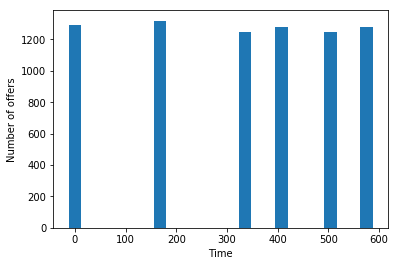

In [5]:

offer_times =expanded_transcript[expanded_transcript['offer id'] == 'ae264e3637204a6fb9bb56bc8210ddfd'][expanded_transcript['event'] == 'offer received']['time'].value_counts()
plt.bar(offer_times.index, offer_times.values, 25)
plt.xlabel('Time')
plt.ylabel('Number of offers')

In [6]:
def create_offer_combo_count(expanded_transcript=expanded_transcript):
    '''Create a count of unique offerings to the customers with respect to what offers, how many and what order
    
    input
    
    expanded transcript- the expanded transcript that includes an offer id column
    
    output
    
    len(unique_offer_combos) - the total number of unique offerings given to customers
    '''
    offer_letters = {'9b98b8c7a33c4b65b9aebfe6a799e6d9' : 'a', 
                'f19421c1d4aa40978ebb69ca19b0e20d' : 'b', 
                '4d5c57ea9a6940dd891ad53e9dbe8da0' : 'c',
                'ae264e3637204a6fb9bb56bc8210ddfd' : 'd',
                '2298d6c36e964ae4a3e7e9706d1fb8c2' : 'e', 
                '2906b810c7d4411798c6938adc9daaa5' : 'f',
                'fafdcd668e3743c1bb461111dcafc2a4' : 'g', 
                '0b1e1539f2cc45b7b9fa7c272da2e1d7' : 'h',
                '3f207df678b143eea3cee63160fa8bed' : 'i',
                '5a8bc65990b245e5a138643cd4eb9837' : 'j'
               }
    g =expanded_transcript[expanded_transcript['offer id'] == 'ae264e3637204a6fb9bb56bc8210ddfd'][expanded_transcript['event'] == 'offer received']['time'].value_counts()

    unique_offer_combos= []
    for customer in profile['id']:
        everything = expanded_transcript[expanded_transcript['person'] == customer]
        received = everything[everything['event'] == 'offer received']
        he = ''
        for window in np.sort(g.index.values):
            if window in received['time'].values:
                eyed_e = received[received['time'] == window]['offer id'].values[0]
                he += offer_letters[eyed_e]
            else:
                he += '-'
        if he not in unique_offer_combos:
            unique_offer_combos.append(he)
    return (len(unique_offer_combos))

In [7]:
unique_offer_combos = create_offer_combo_count()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


<Container object of 2 artists>

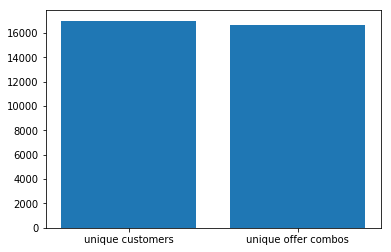

In [9]:
plt.bar(['unique offer combos', 'unique customers'],[unique_offer_combos, len(profile)])

In [4]:
def make_completion_rows(transcript, info_trans):
    
    '''
    Takes information about whether a customer completed a transaction during an informational offer and makes a
    completion row if they did. Usually run conditionally within create_offered_unoffered_dicts because that function creates
    variables needed for this function.
    
    input 
    transcript- a copy of the transcript to add rows to. Typically this is the expanded transcript that is being used by 
            create_offered_unoffered_dicts
    info_trans - a list of dictionaries containing the offer id as key, the start and end dates of the offer and index locations
        for all customer transactions in the offer period
        
    output
    transcript - the transcript inputed with the completion rows added
            
    '''
    count = 0
    while len(info_trans) >count:
        info_dict = info_trans[count]
        offer_id = list(info_trans[count])[0]#info_trans[0].keys().tolist()
        offer_end = info_dict[offer_id][0][1]
        index = info_dict[offer_id][1]
            
        
        if len(index) >0:
            new_idx = float(index[0]) +.1

            transcript.loc[new_idx] = ['offer completed', transcript.loc[index[0]]['person'], offer_end, [{'offer id' : offer_id, 'reward': 0}], offer_id,np.nan, np.nan]
        else:
            pass
        count += 1
    return (transcript)

In [5]:
def create_offered_unoffered_dicts(customer, transcript=expanded_transcript):
    
    '''
    Creates the info that fills offered_dict and unoffered_dict, namely offer start and end dates as well as index locations
    for transactions in each appropriate category.
    
    inputs
    
    customer- id for the customer. This typically comes from a for loop that goes through every customer in the record.
    transcript- a copy of the transcript, typically the expanded transcript since we do a lot of searching by offer id
    
    outputs
    
    offered_customer_dict - a dictionary with offer ids as keys and offer start and end dates as well as index locations for 
    transactions in the offer period
    
    unoffered_list- a list of indexes of transactions that fall outside an offer period
    
    transcript - the transcript with all of the added rows from make_completion_rows, usually saved as added_transcript
    '''
    
    info_only_ids = portfolio[portfolio['offer_type'] == 'informational']
    
    unoffered_list = []
    offered_list = []
    offered_customer_dict = {}
    everything = transcript[transcript['person'] == customer]
    transactions = everything[everything['event'] == 'transaction']
        
    transaction_times = transactions['time']
    completions = everything[everything['event'] == 'offer completed']
    completion_times = completions['time']   
        
    received = everything[everything['event'] == 'offer received']
        
    received_info = received[received['offer id'].isin(info_only_ids['id'].values)]   
        
    info_trans = []
    for receipt in received.iterrows():
            
        iloc = receipt[0]
        offer_id = receipt[1]['offer id']
            
        offer_row = portfolio[portfolio['id'] == offer_id]
                
        offer_length = offer_row['duration']
        offer_hours = 24*offer_length
        offer_start = received.loc[iloc]['time']
        offer_end= offer_start+ offer_hours
        offer_end = offer_end.values[0]
        completions = completion_times.where(everything['time'].isin(np.arange(offer_start, offer_end+1))).dropna().index
        if len(completions) > 0:
            offer_end = everything.loc[completions[0]]['time']
        influenced = transaction_times.where(everything['time'].isin(np.arange(offer_start, offer_end+1))).dropna().index
            
        if offer_id in info_only_ids['id'].values:
            influenced_dict = {offer_id: ((offer_start, offer_end),influenced)}
            info_trans.append(influenced_dict)
            transcript = make_completion_rows(transcript, info_trans)    
                
                
        offered_customer_dict[offer_id] = ((offer_start, offer_end),influenced)
        transaction_times.drop(influenced)       
        
    unoffered_list.append(transaction_times.index)
             
        
    return (offered_customer_dict, unoffered_list, transcript)

In [6]:
offered_dict = {}
unoffered_dict = {}
for customer in transcript['person'].unique():
    
    offered_customer_dict, unoffered_list, added_transcript = create_offered_unoffered_dicts(customer)
    offered_dict[customer] = offered_customer_dict
    unoffered_dict[customer] = unoffered_list

In [8]:
added_transcript.to_csv('added_transcript_save', index = False)

In [9]:
np.save('uo_dict.npy', unoffered_dict)
np.save('o_dict.npy', offered_dict)

In [10]:
unoffered_dict = np.load('uo_dict.npy').item()
offered_dict = np.load('o_dict.npy').item()

In [11]:
added_transcript = pd.read_csv('added_transcript_save')

In [24]:
def create_timings(expanded_transcript=added_transcript):
    '''
    Reshape the exapanded transcript.
    
    input
    expanded_transcript- the transcript file (with modifications) to be transformed
    
    output
    timings - reshaped transcript with multiindex of customer id, offer id and the times for offer recieved, offer viewed,
    and offer completed 
    '''

    timings = pd.pivot_table(expanded_transcript, values = 'time', index = ['person', 'offer id'], columns = 'event', aggfunc = pd.Series.tolist)
    return (timings, expanded_transcript)

timings, expanded_transcript = create_timings()


In [25]:
def create_rewards_column(timings=timings):
    '''
    Add a 'rewards' column to the 'timings' DataFrame
    
    input 
    timings- the timings DataFrame created from the transcript
    
    output
    rewards_list = a list designed to be used as a new column in timings
    '''
    rewards_dict = {}
    for i in np.arange(len(portfolio)):
        rewards_dict[portfolio['id'][i]] = portfolio['reward'][i]
    rewards_list = []
    #for id in master_list.reset_index()['level_1']:
    for id in timings.reset_index()['offer id']:
        rewards_list.append(rewards_dict[id])
    return (rewards_list)
timings['reward'] = create_rewards_column()    

In [16]:
def check_views_completions(customer_offer_pair):
    #No view or completion should be yes?
    '''
    Checks the timings for each pairing of customer and offer and returns an integer to be used by make_decision
    
    input
    customer_offer_pair - info from a row of the DataFrame used by make_decision
    
    output
    int - used by make_decision for making a decision
    '''
    try:
        z = customer_offer_pair[1]['offer viewed'][0] - customer_offer_pair[1]['offer completed'][0]
    except:
        z = np.nan
    #print (z)
    if type(customer_offer_pair[1]['offer completed']) == float:
        if np.isnan(customer_offer_pair[1]['offer completed']):
            return (0)
        else:
            return (3)
    elif type(customer_offer_pair[1]['offer viewed']) == float:
        if np.isnan(customer_offer_pair[1]['offer viewed']):
            return (0)
        else:
            return (3)
    elif len(customer_offer_pair[1]['offer completed']) > len(customer_offer_pair[1]['offer viewed']):
        return (0)
    elif customer_offer_pair[1]['offer viewed'][0] > customer_offer_pair[1]['offer completed'][0]:
        return (0)
    elif len(customer_offer_pair[1]['offer viewed']) == 2:
        if len(customer_offer_pair[1]['offer completed']) ==2:
            if customer_offer_pair[1]['offer viewed'][1] > customer_offer_pair[1]['offer completed'][1]:
                return (0)
            else:
                pass
        else:
            pass
    elif len(customer_offer_pair[1]['offer viewed']) == 3:
        if len(customer_offer_pair[1]['offer completed']) ==3:
            if customer_offer_pair[1]['offer viewed'][2] > customer_offer_pair[1]['offer completed'][2]:
                return (0)
            else:
                pass
        else:
            pass
    else:
        return(1)

In [17]:
def calculate_offer_time(customer_id, offer_id):
    '''
    Calculate the length of an offer period.
    
    inputs
    customer_id - used as the key for top level of the nested offered_dict and unoffered_dict
    offer_id - used as the key for second level of the nested offered_dict and unoffered_dict
    
    outputs
    
    '''
    offer_time = offered_dict[customer_id][offer_id][0][1] - offered_dict[customer_id][offer_id][0][0]
    return offer_time

In [18]:
def get_transaction_amounts(customer_id, offer_id):
    '''
    Create lists of amounts spent for the offer period and outside any offer period using data from offered_dict and
    unoffered_dict as well as the transcript.
    
    inputs
    customer_id - used as the key for top level of the nested offered_dict and unoffered_dict
    offer_id - used as the key for second level of the nested offered_dict and unoffered_dict
    
    output
    offer_amounts - list of amounts spent during offer period
    noffered_amounts - list of amounts spent outside any offer period
    '''
    unoffered_amounts = []
    offer_amounts = []
    for index in offered_dict[customer_id][offer_id][1]:
        offer_amounts.append(transcript.loc[index]['value']['amount'])
    for index in unoffered_dict[customer_id][0]:
        unoffered_amounts.append(transcript.loc[index]['value']['amount'])
    return (offer_amounts, unoffered_amounts)


In [19]:
def value_calculation(offer_id, customer_id, reward):
    '''
    A function for assessing customer behavior. Returns the difference in spending per hour for the customer between times
    when there is no offer and during the offer period in question. 
    
    inputs:
    
    offer_id - the id for the offer in question
    customer_id - the id for the customer in question
    reward - the reward amount for the offer in question
    ---
    outputs: 
    spending_gain - difference between total offer spending (minus reward) per hour and unoffered spending per hour
    '''
    total_offer_time = 0
    for offer in offered_dict[customer_id]:
        offer_time = calculate_offer_time(customer_id, offer)
        total_offer_time += offer_time
    offer_amounts, unoffered_amounts = get_transaction_amounts(customer_id, offer_id)
    baseline = np.sum(unoffered_amounts)/(714-total_offer_time)
    offer_period = np.sum(calculate_offer_time(customer_id, offer_id))
    
    offer_spending = np.sum(offer_amounts)-reward/offer_period
    spending_gain = offer_spending - baseline
    #https://ycharts.com/companies/SBUX/gross_profit_margin
    #gain_cost = (spending_gain*.7221) + reward/np.sum(calculate_offer_time(customer_id, offer_id))#<----- best way to calc? 
    #profitability = spending_gain - gain_cost
    if np.isnan(spending_gain):
        spending_gain = 0
    else:
        pass
    return (spending_gain)


In [26]:
def make_decision(master_list):
    '''
    Use the the check_views_completions and value_calculation functions to make a decision on whether a customer should 
    recieve a particular offer.
    
    input
    master_list- the master file created from the transcript (includes timings and rewards)
    
    output
    decision- a list of 'Yes'/'No' decisions to form a column in master_list
    '''
    decision = []
    for customer_offer_pair in master_list.iterrows():
        #print (customer_offer_pair)
        customer_id = customer_offer_pair[0][0]
        offer_id = customer_offer_pair[0][1]
        reward_amt = customer_offer_pair[1]['reward']
        if check_views_completions(customer_offer_pair) == 0:
            decision.append('No')
        elif check_views_completions(customer_offer_pair) == 2:
            decision.append('Inc')
        #elif value_calculation(np.mean(customer_offer_pair[1]['trans_amount']), customer_id, reward_amt) < 0:
        elif value_calculation(offer_id, customer_id, reward_amt) < 0:
            decision.append('No')
        #elif not completed
        else:
            decision.append('Yes')
    return(decision)
timings['decision']  =make_decision(timings)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in long_scalars
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in long_scalars
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars


In [48]:
master_list = pd.concat([timings, amounts], axis = 1)

In [49]:
master_list.to_csv('master_list_save')

In [3]:
master = pd.read_csv('master_list_save')

In [28]:
timings.to_csv('timings_save')

In [35]:
timings =  pd.read_csv('timings_save')

In [30]:
def convert_date(num):
    '''
    Take a date in format YYYYMMDD and convert it into the number of days from that date to the day after the last signup.
    
    input
    num - the YYYYMMDD date from the profile
    
    output
    diff.days - the differnce between the "current" date (day after last signup) and the date inputed, converted to days. 
    
    '''
    date = datetime.strptime(str(num), '%Y%m%d')
    #day after last sign up in profile
    start_date = datetime.strptime(str(20180727), '%Y%m%d')
    diff = start_date -date #date.days()
    return (diff.days)

In [36]:
timings

,person,offer id,offer completed,offer received,offer viewed,reward,decision
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,[576],[576],NaN,2,No
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,[414],[336],[372],0,Yes
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,[240],[168],[192],0,Yes
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,[414],[408],[456],5,No
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,[528],[504],[540],2,No
5,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,NaN,"[168, 576]","[216, 630]",5,No
6,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,[576],[408],[432],5,Yes
7,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,[252],[168],[186],3,Yes
8,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,NaN,[0],[6],0,No
9,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,NaN,[336],[354],0,No


In [37]:
def clean_profile_and_timings(profile=profile, timings = timings):
    '''
    Remove NaN rows from the profile and remove related entries from the master
    
    inputs
    profile- the original unaltered profile
    master- the master file created from the transcript (includes timings, rewards and decision)
    
    outputs
    cleaned_profile - profile with NaNs removed
    cleaned_master- master with customers not in cleaned_profile removed
    '''
    cleaned_profile = profile.dropna()
    drop = profile[profile['age']== 118]['id']
    cleaned_timings = timings
    for user_id in drop:
        cleaned_timings = cleaned_timings[cleaned_timings['person'] != user_id]
    
    
    
    return (cleaned_profile, cleaned_timings)
cleaned_profile, cleaned_timings = clean_profile_and_timings()

In [5]:
def clean_profile_and_master(profile=profile, master=master):
    '''
    Remove NaN rows from the profile and remove related entries from the master
    
    inputs
    profile- the original unaltered profile
    master- the master file created from the transcript (includes timings, rewards and decision)
    
    outputs
    cleaned_profile - profile with NaNs removed
    cleaned_master- master with customers not in cleaned_profile removed
    '''
    cleaned_profile = profile.dropna()
    drop = profile[profile['age']== 118]['id']
    cleaned_master = master
    for user_id in drop:
        cleaned_master = cleaned_master[cleaned_master['Unnamed: 0'] != user_id]
    
    
    
    return (cleaned_profile, cleaned_master)
cleaned_profile, cleaned_master = clean_profile_and_master()

In [38]:
from sklearn.preprocessing import StandardScaler
def preprocess_profile(profile = profile):
    '''Run preprocessing on the profile.
    
    input
    profile- a version of the profile (normally cleaned_profile from clean_profile_and_master)
    
    output
    preprocessed_profile - profile after preprocessing(convert_date, scaling, and one-hot encoding)
    '''
    profile['days_member'] = profile['became_member_on'].apply(convert_date)
    preprocessed_profile = profile.drop(columns='became_member_on')
    scaler = StandardScaler() 
    num = ['age', 'income', 'days_member']

    #preprocessed_profile[num] = scaler.fit_transform(preprocessed_profile[num])
    preprocessed_profile.set_index('id', inplace = True)
    preprocessed_profile = pd.get_dummies(preprocessed_profile)
    return(preprocessed_profile)
preprocessed_profile = preprocess_profile(cleaned_profile)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [39]:
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
clf =  RandomForestClassifier()
clf_2 = DummyClassifier()

In [46]:
def train_and_predict(offer, cleaned_timings = cleaned_timings, preprocessed_profile = preprocessed_profile, clf =clf,
                      clf_2 =clf_2):
    '''
    Trains the classifier and makes predictions for the one offer in the dataset.
    offer - one of the ten offers in the portfolio file
    
    inputs
    cleaned_master - the master list of 'decision' labels for user-offer combos cleaned of users with missing data.
    preprocessed_profile - the profile with missing data removed and 
    clf - the classifier we are testing
    clf_2 - a dummy classifier for comparison
    
    outputs
    
    '''
    
    offer_set = cleaned_timings[cleaned_timings['offer id'] == offer]
   
    X =pd .DataFrame(offer_set['person']).merge(preprocessed_profile, left_on = 'person', right_on = 'id')
    
    X.drop('person', axis = 1, inplace = True)

    
    y = offer_set.set_index('person')['decision']
    
    
    
    
    X_train, X_test, y_train, y_test = train_test_split(X,y)

    clf.fit(X_train, y_train)

    preds = clf.predict(X_test)
    
    acc = classification_report(y_test, preds)

    print ('Dummy for {} #{}:\n{}'.format(offer_labels[offer][0],offer_labels[offer][1],acc ))

for offer in list(offer_labels.keys()):

    train_and_predict(offer)


Dummy for Bogo 5 #0:
             precision    recall  f1-score   support

         No       0.73      0.88      0.80       992
        Yes       0.40      0.20      0.27       394

avg / total       0.64      0.69      0.65      1386

Dummy for Bogo 5 #1:
             precision    recall  f1-score   support

         No       0.54      0.61      0.57       680
        Yes       0.55      0.47      0.51       682

avg / total       0.54      0.54      0.54      1362

Dummy for Bogo 10 #0:
             precision    recall  f1-score   support

         No       0.68      0.78      0.72       843
        Yes       0.54      0.41      0.47       535

avg / total       0.62      0.64      0.62      1378

Dummy for Bogo 10 #1:
             precision    recall  f1-score   support

         No       0.69      0.78      0.73       897
        Yes       0.47      0.35      0.40       494

avg / total       0.61      0.63      0.61      1391

Dummy for Disc 7 #0:
             precision    recall 

In [47]:
clf.feature_importances_

array([ 0.2737189 ,  0.30401286,  0.40818142,  0.00628641,  0.00546661,
        0.00233381])